In [649]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd
import warnings
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.sm_exceptions import ValueWarning
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
from datetime import timedelta  
%matplotlib inline 
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 9999)
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm.notebook import tqdm

In [650]:
orders = pd.read_csv("orders.csv")
partners_delays = pd.read_csv("partners_delays.csv")

Для предсказания количества заказов по дням попробуем использовать библиотеку `Prophet` от Facebook, а также модель `SARIMAX`.
Поскольку для `Prophet` не критично отсутствие значений в некоторые периоды времени, можно сразу перейти к прогнозированию. В качестве тестовой выборки используем данные по региону с `delivery_area_id` = 0. Так как в разных регионах распределение количества заказов по времени можно считать одинаковым, то полученные результаты будут обощены на все остальные регионы.

In [651]:
zz = orders[orders.delivery_area_id == 0].drop(columns='delivery_area_id')
zz = zz.rename(columns={"date": "ds", "orders_cnt": "y"}) # renaming for Prophet :)
zz['ds'] = pd.to_datetime(zz['ds'])

In [652]:
train = zz[:2801]
test  = zz[2801:]

In [653]:
m = Prophet()
m.fit(train)

18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing


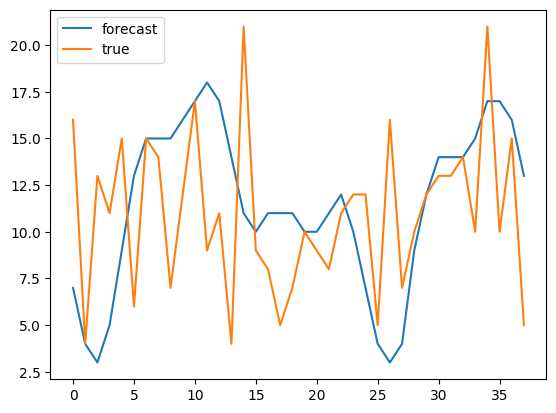

In [654]:
future = m.make_future_dataframe(periods=39, freq = 'H')
forecast = m.predict(future)
plt.plot(round(forecast['yhat'][-38:]).reset_index(drop=True), label='forecast')
plt.plot(test['y'].reset_index(drop=True), label='true')
plt.legend(loc='best') 

In [655]:
type(forecast['yhat'])

pandas.core.series.Series

In [656]:
y_pred = round(forecast['yhat'][-38:].reset_index(drop=True))
y_true = test['y'].reset_index(drop=True)
print("Prophet RMSE: " + str(sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))))

Prophet RMSE: 5.474822756083188


Судя по графику, модель не очень хорошо предсказывает количество заказов. Попробуем модель `SARIMA`. Поскольку в данных за каждый день есть информация только о 10 часах, будем предполагать, что в остальное время количество заказов равно 0.

In [657]:
zz = orders[orders.delivery_area_id == 0].drop(columns='delivery_area_id')
zz = zz.rename(columns={"date": "ds", "orders_cnt": "y"}) # renaming for Prophet :)
zz['ds'] = pd.to_datetime(zz['ds'])
zz.set_index('ds', inplace = True)
idx = pd.period_range(min(zz.index), max(zz.index), freq = 'H')
idx = pd.DataFrame(idx, columns=['ds'])
nc = [0] * idx.shape[0]
nc = pd.DataFrame(nc, columns=['y'])
full_data = pd.concat([idx, nc], axis=1)
full_data['ds'] = full_data['ds'].astype(str)
full_data['ds'] = pd.to_datetime(full_data['ds'])
full_data.set_index('ds', inplace = True)
full_data = pd.concat([full_data.index.to_frame(), full_data['y']], axis=1)
full_data.reset_index(drop=True, inplace=True)

zz = pd.concat([zz.index.to_frame(), zz['y']], axis=1)
zz.reset_index(drop=True, inplace=True)

count = 0
data = full_data.copy(deep=True)
for i in range(0, data.shape[0]):
    if data['ds'][i] in zz['ds'].values:
        data.at[i, 'y'] = zz['y'][count]
        count = count + 1;
        
del zz, idx, nc, full_data, count
data.set_index('ds', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5844 entries, 2021-04-01 10:00:00 to 2021-11-30 21:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       5844 non-null   int64
dtypes: int64(1)
memory usage: 91.3 KB


Проверим данные на стационарность при помощи теста Дики-Фуллера

In [658]:
adf_test = adfuller(data.y)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.425663
p-value: 0.010115
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Видно, что данные можно считать стационарными. Для уверенности, что и в остальных случаях данные будут стационарными, возьмем ряд из разностей и проверим его на стационарноть, чтобы определить порядок интегрированности временного ряда.

In [659]:
adf_test = adfuller(data.y.diff().dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.869390
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Ряд из первых разностей можно уверенно считать стационарным. Таким образом, порядок интегрированности модели (`d`) равен 1.

In [660]:
train = data[:5801]
test  = data[5801:]

Построим графики автокорреляционной функции и частичной автокорреляционной функции, чтобы можно было оценть параметры модели.

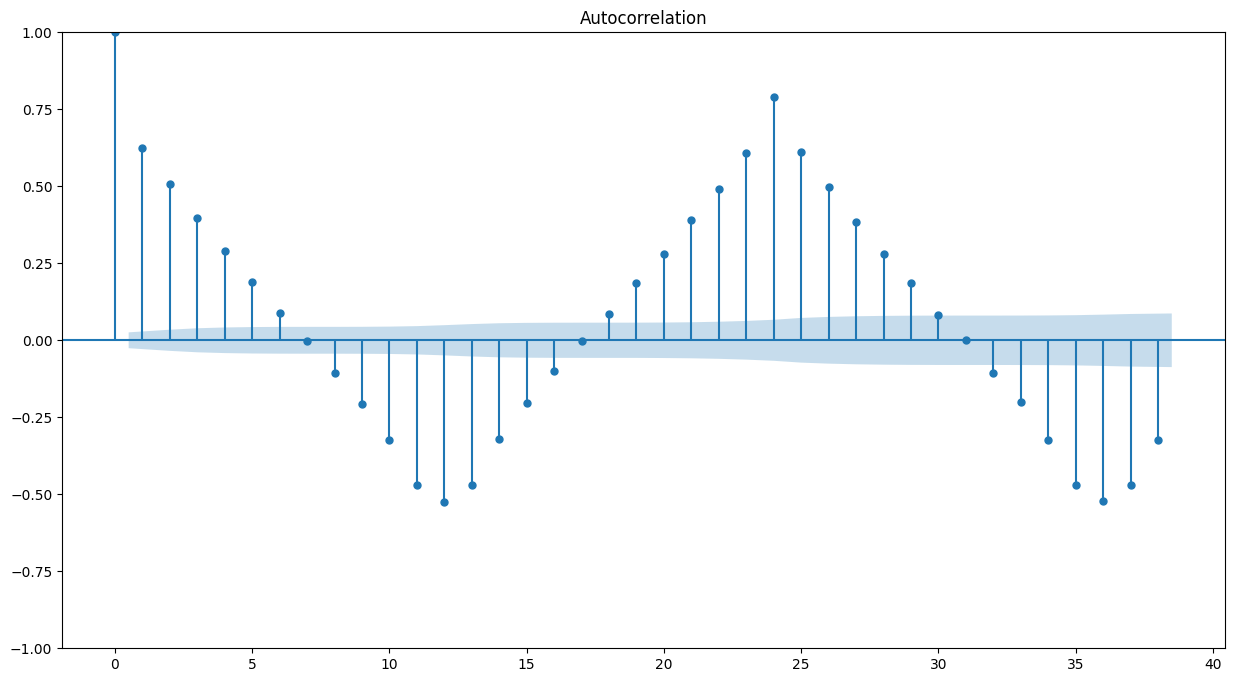

In [661]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(train, ax=ax);

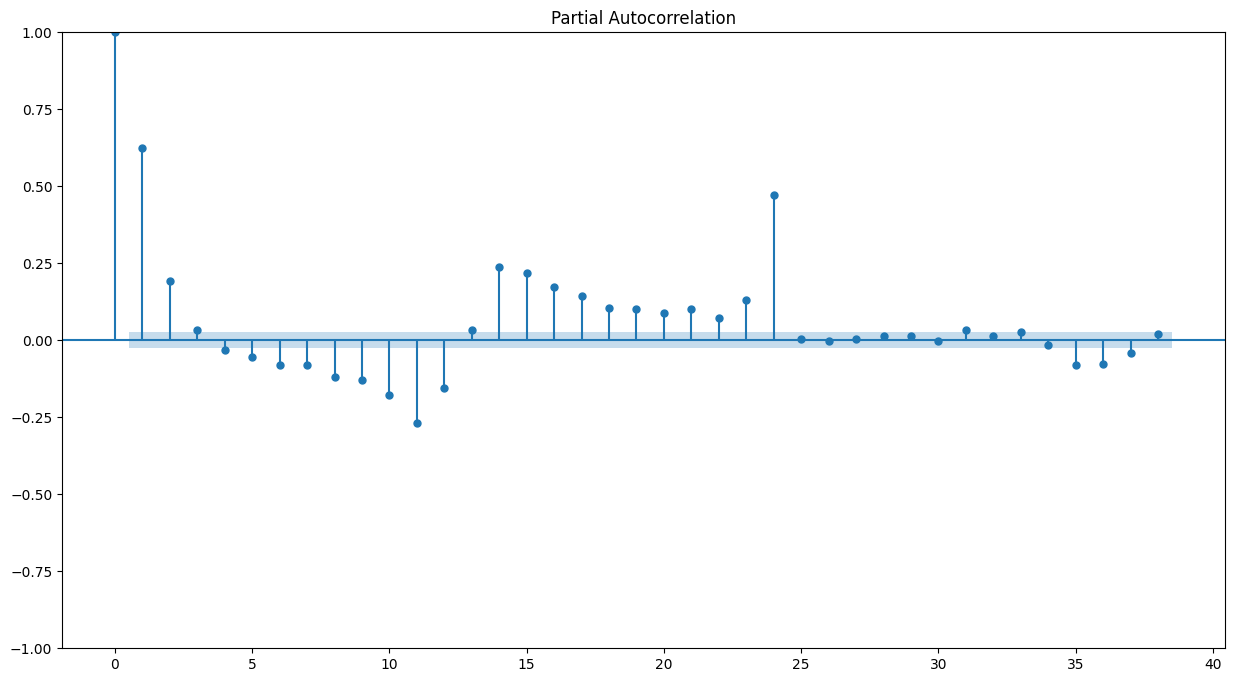

In [662]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(train, method='ywm', ax=ax);

В данных явно присутствует сезонность, однако однозначно определить параметры модели исходя из этих графиков не получается. Попробуем автоматический подбор параметров.

In [663]:
model_autoarima_iter = auto_arima(train, seasonal=True,m=24, trace=True, maxiter=120)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=24.03 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=30862.879, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=28003.377, Time=1.59 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=28620.025, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=30860.880, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=30143.408, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=12.26 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.14 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=28946.366, Time=1.58 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=41.42 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=29301.117, Time=1.54 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=27573.452, Time=2.36 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=30026.967, Time=0.20 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=inf, Time=16.10 sec
 ARIMA(2,1,0)(1,0,1)[24] interc

Получилось, что модель ARIMA(5,1,0)(1,0,0)\[24\] является наилучшей (минимизирует информационный критерий Акаике `AIC`). Посмотрим как данная модель справляется на тестовой выборке.

Модель должна производить целые неотрицательные числа, нужно это контролировать. Также заказов не может быть в период с 22:00 до 10:00.

In [664]:
def adjust_predicts(p):
    p = round(p)    
    idx = 0
    for i, v in p.items():
        if p[idx] < 0 or i.hour < 10 or i.hour > 21:
            p[idx] = 0
        idx = idx + 1
    return p
    
def adjust_prophet_predicts(p):
    p = round(p)
    for i in range(0, len(p)):
        if p[i] <= 0:
            p[i] = 1
    return p

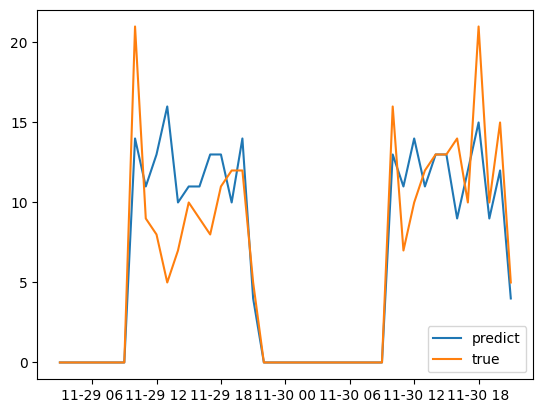

In [670]:
warnings.simplefilter('ignore', ValueWarning)
model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 0, 24))
model_fit = model.fit()
start_datetime = train.index[-1] + timedelta(hours=1)
end_datetime = start_datetime + timedelta(hours=42)
predict = model_fit.predict(start=start_datetime, end=end_datetime)
predict = adjust_predicts(predict)
plt.plot(round(predict), label='predict')
plt.plot(test, label='true')
plt.legend(loc='best')

In [671]:
predict.values
test.values
y_pred = round(predict)
y_true = test.values
print("SARIMAX RMSE: " + str(sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))))

SARIMAX RMSE: 2.9294018756116764


Значение `RMSE` для `SARIMAX` значительно меньше, чем для `Prophet`, поэтому в дельнейшем для прогноза колчиества заказов по часам будет использоваться модель `SARIMAX(5, 1, 0)(1, 1, 0)[24]`

Теперь, когда все определено, необходимо для каждой области доставки сгенерировать прогноз на 7 дней вперед и поместить полученные данные вместе с историей.

In [638]:
len(set(orders['delivery_area_id']))

593

In [639]:
new_orders = orders.copy(deep=True)
new_orders = new_orders.squeeze()
new_orders['date'] = pd.to_datetime(new_orders['date'])

area_id = 0

for i in tqdm(range(0, 593)):
    zz = orders[orders.delivery_area_id == area_id].drop(columns='delivery_area_id')
    zz = zz.rename(columns={"date": "ds", "orders_cnt": "y"}) # renaming for Prophet :)
    zz['ds'] = pd.to_datetime(zz['ds'])
    zz.set_index('ds', inplace = True)
    idx = pd.period_range(min(zz.index), max(zz.index), freq = 'H')
    idx = pd.DataFrame(idx, columns=['ds'])
    nc = [0] * idx.shape[0]
    nc = pd.DataFrame(nc, columns=['y'])
    full_data = pd.concat([idx, nc], axis=1)
    full_data['ds'] = full_data['ds'].astype(str)
    full_data['ds'] = pd.to_datetime(full_data['ds'])
    full_data.set_index('ds', inplace = True)
    full_data = pd.concat([full_data.index.to_frame(), full_data['y']], axis=1)
    full_data.reset_index(drop=True, inplace=True)
    zz = pd.concat([zz.index.to_frame(), zz['y']], axis=1)
    zz.reset_index(drop=True, inplace=True)
    count = 0
    data = full_data.copy(deep=True)
    for i in range(0, data.shape[0]):
        if data['ds'][i] in zz['ds'].values:
            data.at[i, 'y'] = zz['y'][count]
            count = count + 1;
    del idx, nc, full_data, count
    
    data.set_index('ds', inplace = True)
    
    warnings.simplefilter('ignore', ValueWarning)
    model = SARIMAX(data, order=(5, 1, 0), seasonal_order=(1, 1, 0, 24))
    model_fit = model.fit()
    start_datetime = data.index[-1] + timedelta(hours=1)
    end_datetime = start_datetime + timedelta(days=7)
    predict = model_fit.predict(start=start_datetime, end=end_datetime)
    
    p = adjust_predicts(predict)
    p = p.to_frame(name='orders_cnt')
    dai = [area_id] * len(predict)
    p['delivery_area_id'] = dai
    p['date'] = p.index.to_series()
    p = p.reset_index(drop = True)
    p = p[['delivery_area_id', 'date', 'orders_cnt']]
    p = p.loc[(p['date'].dt.hour >= 10) & (p['date'].dt.hour <= 21)]
    if max(p['orders_cnt'] > max(data['y'] + 7)):
        m = Prophet(changepoint_prior_scale=0.01)
        m.fit(zz[-140:])
        future = m.make_future_dataframe(periods=70, freq = 'H')
        forecast = m.predict(future)
        forecast = adjust_prophet_predicts(forecast['yhat'])
        p['orders_cnt'] = forecast
    new_orders = pd.concat([new_orders, p], ignore_index=True, axis=0)
    area_id = area_id + 1
        
new_orders = new_orders.sort_values(['delivery_area_id', 'date'], ascending=[True, True])
new_orders.to_csv('new_orders.csv', index=False)

  0%|          | 0/593 [00:00<?, ?it/s]

18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:06:34 - cmdstanpy - INFO - Chain [1] done processing
18:06:50 - cmdstanpy - INFO - Chain [1] start processing
18:06:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:09 - cmdstanpy - INFO - Chain [1] start processing
18:07:09 - cmdstanpy - INFO - Chain [1] done processing
18:07:24 - cmdstanpy - INFO - Chain [1] start processing
18:07:24 - cmdstanpy - INFO - Chain [1] done processing
18:07:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
18:07:24 - cmdstanpy - INFO - Chain [1] start processing
18:07:24 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
18:07:53 - cmdstanpy - INFO - Chain [1] start processing
18:07:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:08 - cmdstanpy - INFO - Chain [1] start processing
18:08:

In [672]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884856 entries, 0 to 884855
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   delivery_area_id  884856 non-null  int64 
 1   date              884856 non-null  object
 2   orders_cnt        884856 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 20.3+ MB


In [673]:
new_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934909 entries, 0 to 934908
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   delivery_area_id  934909 non-null  int64         
 1   date              934909 non-null  datetime64[ns]
 2   orders_cnt        934909 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.5 MB
